0


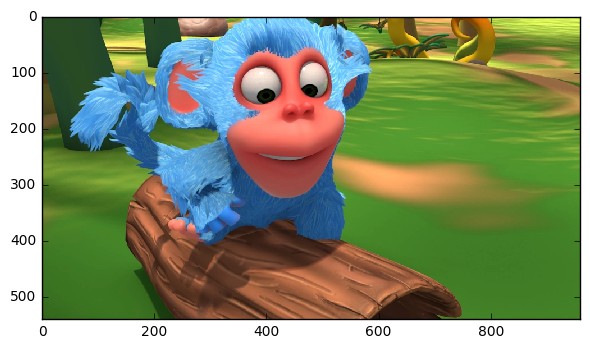

404656
1


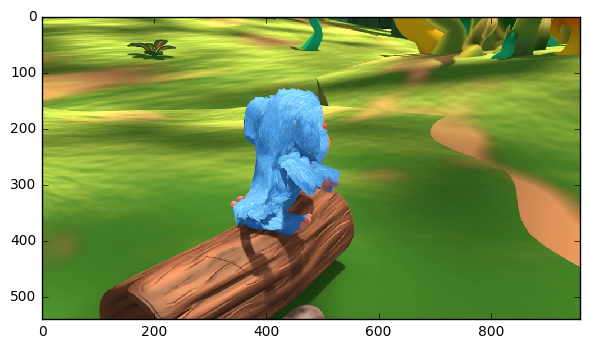

466931
2


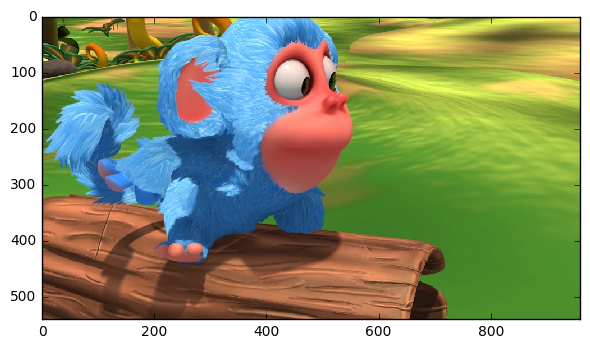

401900
3


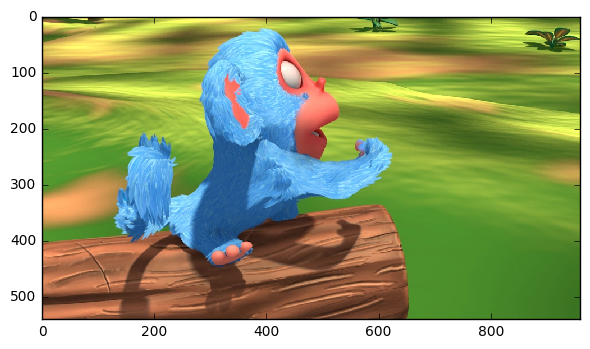

417136
4


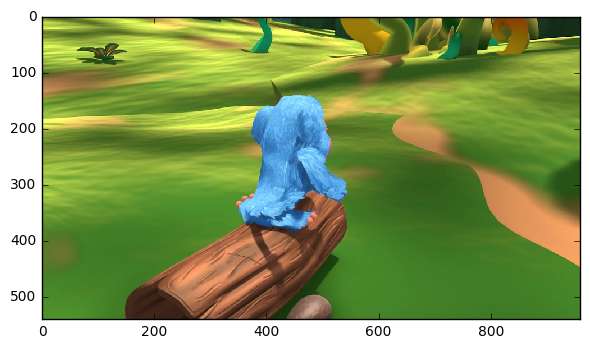

470443
5


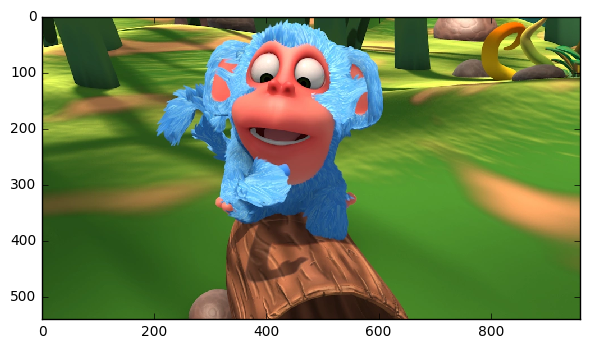

419658
6


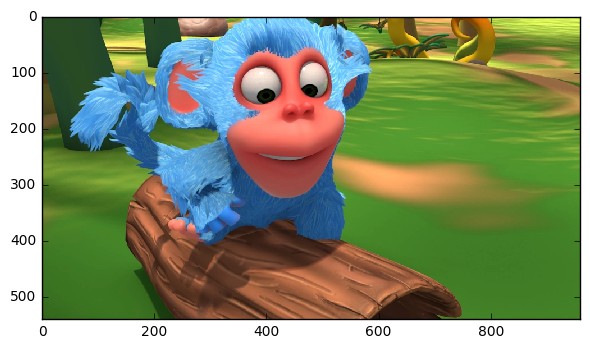

404656
7


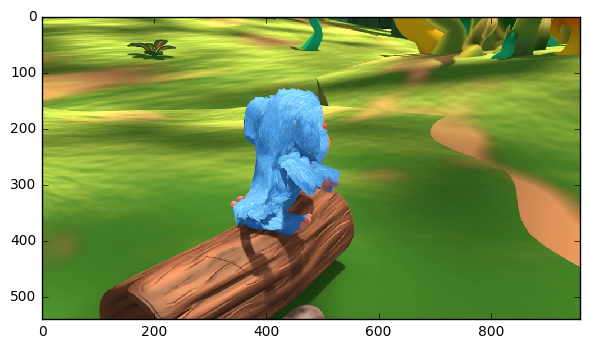

466931
8


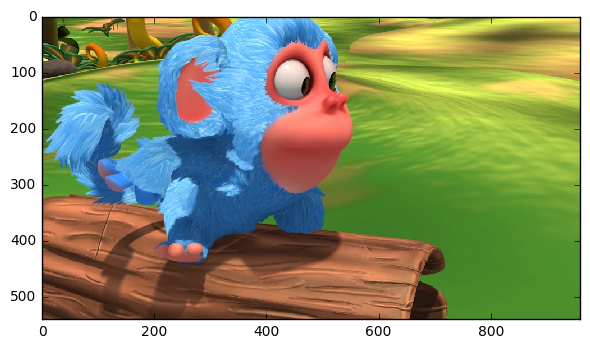

401900
9


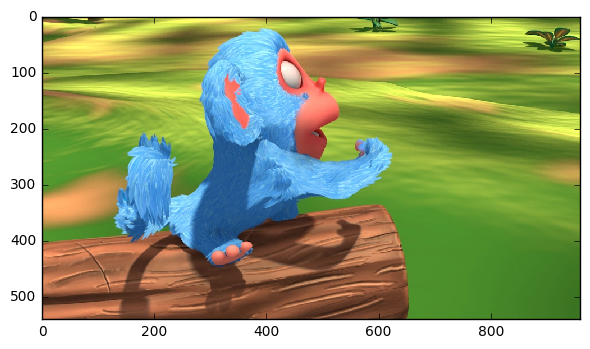

417136
10


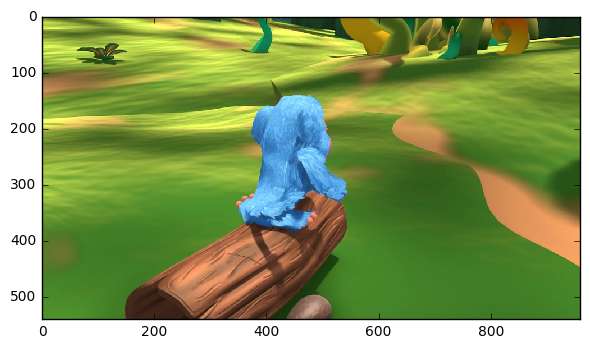

470443
11


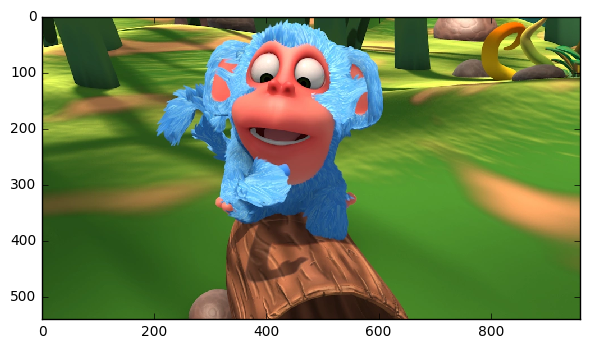

419658
12


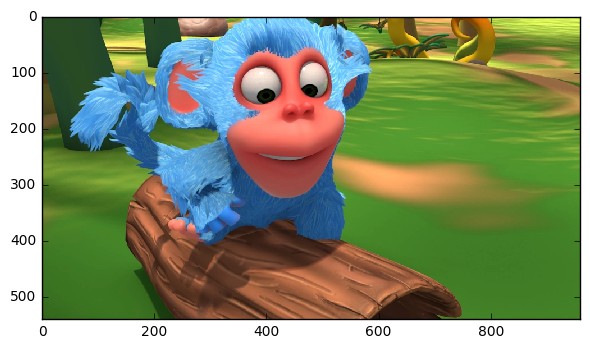

404656
13


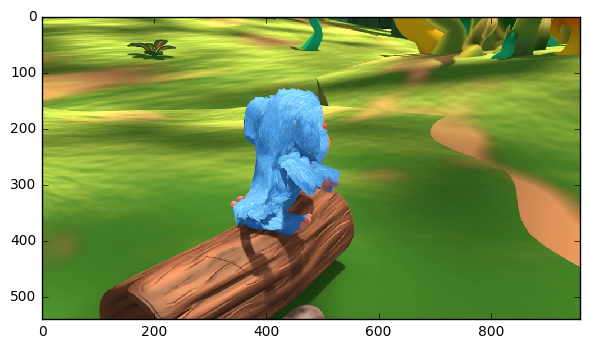

466931
14


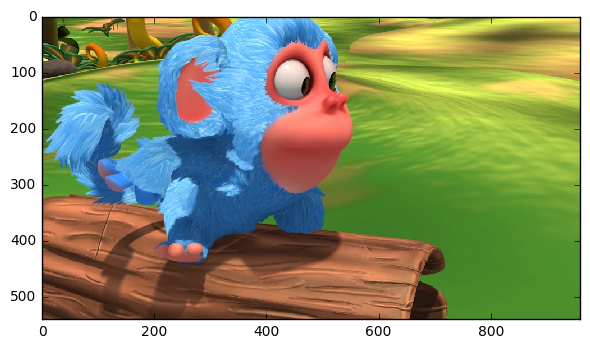

401900
15


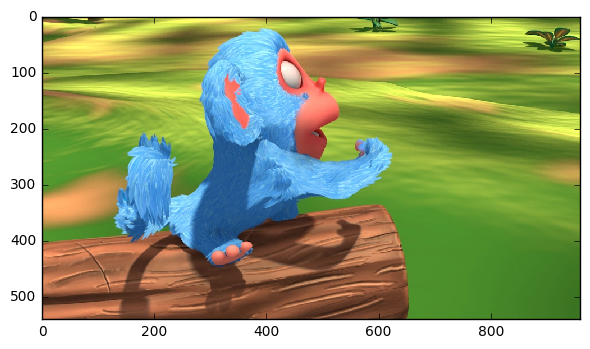

417136
16


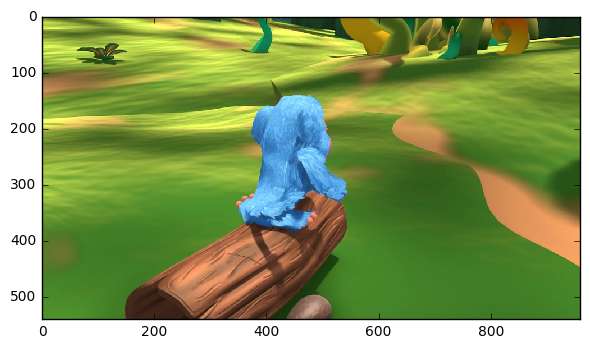

470443
17


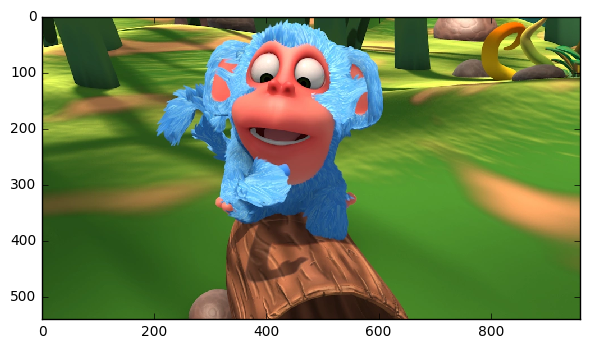

419658
18


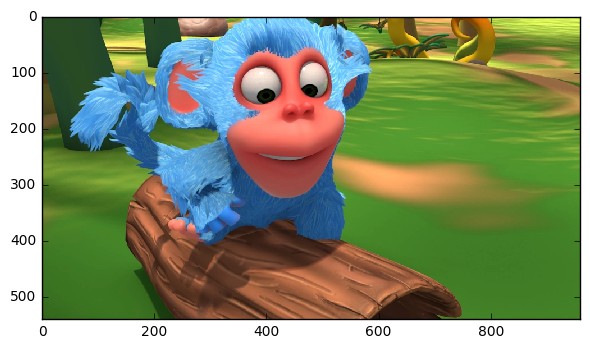

404656
19


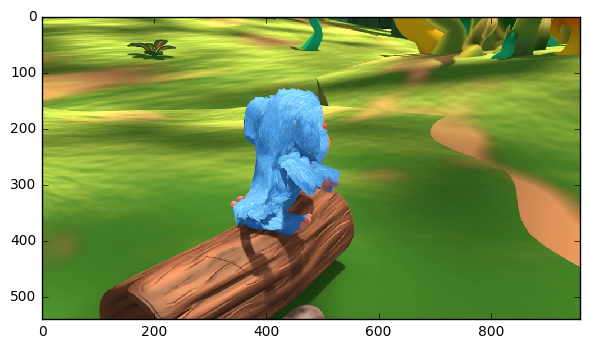

466931


In [6]:
import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 540
IMAGE_WIDTH = 960
DEPTH = 3

tfrecords_filename = '/home/laoreja/dataset/SceneFlow/tfrecords/validation-00000-of-00004'

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'left_image_raw':tf.FixedLenFeature([], tf.string),
        'right_image_raw':tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string),
        'disparity_raw': tf.FixedLenFeature([], tf.string),
        'filename': tf.FixedLenFeature([], tf.string),
        'relative_dir': tf.FixedLenFeature([], tf.string),            
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    left_image = tf.decode_raw(features['left_image_raw'], tf.uint8)
    right_image = tf.decode_raw(features['right_image_raw'], tf.uint8)
    mask = tf.decode_raw(features['mask_raw'], tf.uint8)
    disparity = tf.decode_raw(features['disparity_raw'], tf.float32)
        
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH])
    disparity_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 1])
    
    left_image = tf.reshape(left_image, image_shape)
    right_image = tf.reshape(right_image, image_shape)    
    disparity = tf.reshape(disparity, disparity_shape)
    mask = tf.reshape(mask, disparity_shape)

    #mask, [IMAGE_HEIGHT, IMAGE_WIDTH, 1]
#     left_images, right_images, disparities, masks = tf.train.shuffle_batch( [left_image, right_image, disparity, mask],
#                                                  batch_size=1,
#                                                  capacity=30,
#                                                  num_threads=2,
#                                                  min_after_dequeue=10,
#                                                  shapes=[[IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1],
#                                                          [IMAGE_HEIGHT, IMAGE_WIDTH, 1]])

    left_images, right_images, disparities, masks = tf.train.batch( [left_image, right_image, disparity, mask],
                                                 batch_size=1,
                                                 capacity=30,
                                                 num_threads=1,
                                                 shapes=[[IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
                                                         [IMAGE_HEIGHT, IMAGE_WIDTH, DEPTH], 
                                                         [IMAGE_HEIGHT, IMAGE_WIDTH, 1],
                                                         [IMAGE_HEIGHT, IMAGE_WIDTH, 1]])

    
    return left_images, right_images, disparities, masks
#, masks

filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], shuffle=False)

# Even when reading in multiple threads, share the filename
# queue.
lim, rim, d, m = read_and_decode(filename_queue) #m

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())


with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in xrange(20):
        print i
        _lim, _rim, _d, _m = sess.run([lim, rim, d, m]) #m, _m
#         print(_lim[0, :, :, :].shape)
#         print(_d.shape)
#         print(np.all(np.isclose(_m, np.ones((1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)))))
        
#         print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(_lim[0, :, :, :])
        io.show()

#         io.imshow(_rim[0, :, :, :])
#         io.show()
        
#         io.imshow(_d[0, :, :, 0])
#         io.show()
        
        _d[np.where(np.logical_not(_m))] = 0
        print np.sum(_m)
#         io.imshow(_d[0, :, :, 0])
#         io.show()
        
        
#         print(_d[0, :10, :10, 0])
        
#         io.imshow(_lim[1, :, :, :])
#         io.show()
        
#         io.imshow(_rim[1, :, :, :])
#         io.show()        

#         io.imshow(_d[1, :, :, 0])
#         io.show()
        
    
    coord.request_stop()
    coord.join(threads)